## Training

In [8]:
import sys
!{sys.executable} -m pip install mlxtend

     |████████████████████████████████| 1.4MB 228kB/s eta 0:00:01
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import SCORERS
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, PowerTransformer, power_transform, scale, StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.evaluate import PredefinedHoldoutSplit

### Process Data

In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
OXFORD_DATA_FILE = 'data/OxCGRT_latest.csv'
SOCIAL_EXPLORER_DATA_FILE = '../../../../../data/social_explorer_data.csv'
LODES_DATA_FILE = '../../../../../data/lodes_us_states_rac_S000_JT00_2018.csv'

In [4]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, OXFORD_DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7fe408378130>)

In [56]:
# Load historical data from local file
oxford_data = pd.read_csv(OXFORD_DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [57]:
oxford_data.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [58]:
def transform_data(data):
    # pipe = make_pipeline(StandardScaler(with_std=False), PowerTransformer(standardize=True))
    pipe = make_pipeline(StandardScaler(with_std=True))
    if len(data.shape) == 1:
        transformed_data = pipe.fit_transform(data.reshape(-1,1))
        return (transformed_data, pipe)
    transformed_data = pipe.fit_transform(data)
    return (transformed_data, pipe)
def apply_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.transform(data.reshape(-1,1))
    return pipe.transform(data)
def inverse_transform(pipe, data):
    if len(data.shape) == 1:
        return pipe.inverse_transform(data.reshape(-1,1))
    return pipe.inverse_transform(data)

# Load Census Data

In [59]:
census_data = pd.read_csv(SOCIAL_EXPLORER_DATA_FILE, skiprows=[1])
census_data.drop(columns=['FIPS'], inplace=True)
cols = census_data.columns.values
for feat in cols:
    if 'Employed' in feat or 'Unemployed' in feat:
        census_data.drop(columns=[feat], inplace=True)
    
print(census_data.shape)
# Standardize Census data
census_columns = census_data.columns[1:]
census_regions = census_data['Qualifying Name']
census_data, census_pipe = transform_data(census_data.iloc[:, 1:].values)
census_data = pd.DataFrame(data=census_data,columns=census_columns)
census_data.insert(0, 'Qualifying Name', census_regions)
census_data

(52, 125)


,Qualifying Name,Population Density (Per Sq. Mile),Area (Land),Total Population: Under 5 Years,Total Population: 5 to 9 Years,Total Population: 10 to 14 Years,Total Population: 15 to 17 Years,Total Population: 18 to 24 Years,Total Population: 25 to 34 Years,Total Population: 35 to 44 Years,...,Civilian Veterans 18 Years and Over: Gulf War 1990 to 2001 Only,Civilian Veterans 18 Years and Over: Vietnam Era Only,Civilian Veterans 18 Years and Over: Korean War Only,Civilian Veterans 18 Years and Over: World War Ii Only,Civilian Veterans 18 Years and Over: Served in Multiple Wars,Civilian Veterans 18 Years and Over: Other Service,Total: No Health Insurance Coverage,Total: with Health Insurance Coverage,Total: with Health Insurance Coverage: Public Health Coverage,Total: with Health Insurance Coverage: Private Health Insurance
0,Alabama,-0.215175,-0.205719,-0.199199,-0.198783,-0.202996,-0.187576,-0.200966,-0.224865,-0.213689,...,0.039061,-0.080721,-0.208019,-0.421486,0.191699,-0.122681,-0.110557,-0.208855,-0.169742,-0.212038
1,Alaska,-0.276398,5.959929,-0.731929,-0.747412,-0.756276,-0.766335,-0.770234,-0.719084,-0.752198,...,-0.747459,-0.887403,-0.901944,-0.867852,-0.614532,-0.886682,-0.555751,-0.795989,-0.777952,-0.821000
2,Arizona,-0.237248,0.540818,0.113359,0.131618,0.138640,0.123550,0.127765,0.086748,0.075798,...,0.316304,0.453659,0.422147,0.225583,0.377669,0.388457,0.217436,0.087234,0.193458,0.039680
3,Arkansas,-0.240081,-0.189239,-0.429100,-0.429038,-0.441630,-0.442853,-0.459233,-0.459413,-0.457708,...,-0.389652,-0.434586,-0.497727,-0.475519,-0.385879,-0.487653,-0.366309,-0.468162,-0.365652,-0.526632
4,California,-0.114776,1.040839,4.592685,4.590534,4.595037,4.565413,4.699726,4.854253,4.721176,...,2.949091,3.646399,3.821021,3.871082,2.613342,3.464480,2.922548,4.762437,4.959829,4.513128
5,Colorado,-0.242339,0.422147,-0.108516,-0.083428,-0.096046,-0.112476,-0.105672,-0.002302,-0.034050,...,0.198179,-0.017185,-0.242578,-0.221278,0.397626,-0.062180,-0.156283,-0.089642,-0.165334,-0.065757
6,Connecticut,0.198583,-0.748431,-0.442039,-0.426549,-0.391805,-0.369005,-0.364064,-0.411838,-0.397454,...,-0.649163,-0.525682,-0.293677,-0.139693,-0.613609,-0.488984,-0.443696,-0.366942,-0.379466,-0.369035
7,Delaware,0.039405,-0.782723,-0.728392,-0.745281,-0.733108,-0.745704,-0.752348,-0.711181,-0.733769,...,-0.804243,-0.834524,-0.802812,-0.765562,-0.697551,-0.828171,-0.609088,-0.752938,-0.728092,-0.774127
8,Washington DC,7.025374,-0.805086,-0.750128,-0.788404,-0.799329,-0.814012,-0.766483,-0.678538,-0.742651,...,-0.900891,-0.985987,-0.893013,-0.834360,-0.805959,-0.950983,-0.644596,-0.789312,-0.773587,-0.817492
9,Florida,-0.026119,-0.170159,1.654703,1.638124,1.676872,1.707664,1.703559,1.756218,1.851359,...,2.738107,3.151207,3.604701,3.460848,3.192739,3.287345,2.579642,1.937099,2.142770,1.911235


# Load LODES Data

In [60]:
lodes_data = pd.read_csv(LODES_DATA_FILE, skiprows=[1])
print(lodes_data.shape)

# Standardize lodes data
lodes_columns = lodes_data.columns[1:]
lodes_regions = lodes_data['Qualifying Name']
lodes_data, lodes_pipe = transform_data(lodes_data.iloc[:, 1:].values)
lodes_data = pd.DataFrame(data=lodes_data,columns=lodes_columns)
lodes_data.insert(0, 'Qualifying Name', lodes_regions)
lodes_data

(53, 42)


,Qualifying Name,Total number of jobs,Number of jobs for workers age 29 or younger,Number of jobs for workers age 30 to 54,Number of jobs for workers age 55 or older,Number of jobs with earnings $1250/month or less,Number of jobs with earnings $1251/month to $3333/month,Number of jobs with earnings greater than $3333/month,"Number of jobs in NAICS sector 11 (Agriculture, Forestry, Fishing and Hunting)","Number of jobs in NAICS sector 21 (Mining, Quarrying, and Oil and Gas Extraction)",...,Number of jobs for workers with Race: Native Hawaiian or Other Pacific Islander Alone,Number of jobs for workers with Race: Two or More Race Groups,Number of jobs for workers with Ethnicity: Not Hispanic or Latino,Number of jobs for workers with Ethnicity: Hispanic or Latino,Number of jobs for workers with Educational Attainment: Less than high school,"Number of jobs for workers with Educational Attainment: High school or equivalent, no college",Number of jobs for workers with Educational Attainment: Some college or Associate degree,Number of jobs for workers with Educational Attainment: Bachelor's degree or advanced degree,Number of jobs for workers with Sex: Male,Number of jobs for workers with Sex: Female
0,Alabama,-0.237345,-0.213936,-0.230412,-0.275773,-0.209768,-0.164441,-0.295561,-0.200205,-0.184150,...,-0.341177,-0.411469,-0.173293,-0.353288,-0.217136,-0.172233,-0.220376,-0.330595,-0.234360,-0.240236
1,Alaska,-0.865824,-0.883594,-0.850494,-0.881100,-0.901063,-0.876663,-0.834250,-0.438367,-0.378277,...,-0.438624,-0.668772,-1.006028,-0.420129,-0.665779,-0.960720,-0.890574,-0.827994,-0.856639,-0.874624
2,Arizona,0.031355,0.034509,0.040920,0.005494,-0.015539,0.155554,-0.030617,0.110616,0.011710,...,0.150798,0.151446,-0.134219,0.411710,0.181263,0.004365,0.074060,-0.081960,0.056394,0.005730
3,Arkansas,-0.483416,-0.472554,-0.475204,-0.511537,-0.482123,-0.398271,-0.535616,-0.195300,-0.232225,...,-0.254687,-0.454816,-0.516727,-0.339053,-0.380560,-0.472457,-0.488371,-0.537009,-0.482415,-0.484110
4,California,4.583052,4.440443,4.657457,4.528271,4.390194,4.474175,4.694442,6.767279,0.209085,...,5.925422,6.075217,3.895380,5.545917,5.173131,3.843461,4.516446,4.838509,4.657068,4.504238
5,Colorado,-0.024955,-0.017634,-0.011349,-0.064240,-0.078382,-0.061936,0.023528,-0.075460,0.491041,...,-0.081241,0.083557,-0.056035,0.050716,-0.074049,-0.086525,-0.022939,0.044156,0.003350,-0.053880
6,Connecticut,-0.326978,-0.373062,-0.337227,-0.256122,-0.382184,-0.433348,-0.228592,-0.351246,-0.358849,...,-0.302634,-0.318238,-0.364113,-0.195402,-0.320347,-0.410905,-0.356075,-0.176200,-0.340506,-0.312922
7,Delaware,-0.727732,-0.744303,-0.717359,-0.733023,-0.751390,-0.743141,-0.699655,-0.389317,-0.374781,...,-0.415778,-0.576237,-0.831317,-0.386249,-0.571932,-0.803852,-0.749836,-0.688739,-0.725530,-0.729487
8,Washington DC,-0.765744,-0.766056,-0.748090,-0.804075,-0.828186,-0.802563,-0.705878,-0.438503,-0.378308,...,-0.414301,-0.572693,-0.881802,-0.390011,-0.588858,-0.871125,-0.810949,-0.706741,-0.763591,-0.767421
9,Florida,1.895515,1.815707,1.863420,2.042085,2.066848,2.434878,1.442371,1.001738,-0.228018,...,0.353152,1.157849,1.880115,1.668710,1.910242,2.157473,1.994890,1.577006,1.864976,1.925447


In [61]:
# For testing, restrict training data to that before a hypothetical predictor submission date
SUBMISSION_DATE = np.datetime64("2020-11-30")
oxford_data = oxford_data[oxford_data.Date <= SUBMISSION_DATE]

# Remove current day and previous day because data may be incomplete
# oxford_data = oxford_data.groupby("GeoID", as_index=False).apply(lambda x: x.iloc[:-2])

In [62]:
cols = oxford_data.columns
for col in cols:
    if 'Index' in col or 'Flag' in col or 'Wildcard' in col:
        oxford_data.drop(columns=col, inplace=True)

for idx, row in oxford_data[oxford_data['Date'] == '2020-01-01'].iterrows():
    for elem in row[6:].items():
        if (elem[1] == 0.0):
            continue
        if (np.isnan(elem[1])):
            oxford_data.loc[idx, elem[0]] = 0
        
oxford_data['GeoID'] = oxford_data['CountryName'] + '__' + oxford_data['RegionName'].astype(str)
oxford_data['ConfirmedCases'].fillna(0, inplace=True)
oxford_data['ConfirmedDeaths'].fillna(0, inplace=True)
oxford_data['E3_Fiscal measures'].fillna(0, inplace=True)
oxford_data['E4_International support'].fillna(0, inplace=True)
oxford_data['H4_Emergency investment in healthcare'].fillna(0, inplace=True)
oxford_data['H5_Investment in vaccines'].fillna(0, inplace=True)

def log_data(series):
    df = np.log(series)
    df.replace(-np.inf, 0, inplace=True)
    return df
# Transform non categorical features by taking the natural log
oxford_data['E3_Fiscal measures'] = log_data(oxford_data['E3_Fiscal measures'])
oxford_data['E4_International support'] = log_data(oxford_data['E4_International support'])
oxford_data['H4_Emergency investment in healthcare'] = log_data(oxford_data['H4_Emergency investment in healthcare'])
oxford_data['H5_Investment in vaccines'] = log_data(oxford_data['H5_Investment in vaccines'])

new_oxford = []
# Forward fill for each specific region to handle nan for categorical features
for geoid in oxford_data['GeoID'].unique():
    region_df = oxford_data[oxford_data['GeoID'] == geoid]
    for col in region_df.columns[4:].values:
        region_df[col] = region_df[col].ffill()
    new_oxford.append(region_df)
oxford_data = pd.concat(new_oxford)

oxford_data['NewCases'] = oxford_data.groupby('GeoID').ConfirmedCases.diff().fillna(0)
oxford_data['NewDeaths'] = oxford_data.groupby('GeoID').ConfirmedDeaths.diff().fillna(0)
oxford_data.drop(columns=['Jurisdiction', 'RegionCode'], inplace=True)
oxford_data.drop(columns=['CountryCode'], inplace=True)
# Compute the 7 day moving average
oxford_data["7DMA"] = oxford_data.groupby(
    "GeoID")['NewCases'].rolling(7, center=False).mean().reset_index(0, drop=True)
oxford_data["7DMA"]= oxford_data["7DMA"].fillna(0)


# move column to be earlier
geoid = oxford_data['GeoID']
oxford_data.drop(labels=['GeoID'], axis = 1, inplace = True)
oxford_data.insert(3, 'GeoID', geoid)

oxford_data.drop(columns=['ConfirmedCases', 'ConfirmedDeaths', 'NewDeaths'], inplace=True)
oxford_data.head()

/Users/jackiedong/Documents/usc-xprize-covid/xprize/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/jackiedong/Documents/usc-xprize-covid/xprize/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-62-6d845d58ccda>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df[col] = region_df[col].ffill()


,CountryName,RegionName,Date,GeoID,C1_School closing,C2_Workplace closing,C3_Cancel public events,C4_Restrictions on gatherings,C5_Close public transport,C6_Stay at home requirements,...,E4_International support,H1_Public information campaigns,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H7_Vaccination policy,NewCases,7DMA
0,Aruba,NaN,2020-01-01,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Aruba,NaN,2020-01-02,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Aruba,NaN,2020-01-03,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Aruba,NaN,2020-01-04,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Aruba,NaN,2020-01-05,Aruba__nan,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases', '7DMA']
npi_cols_categorical = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']

# To be used later
census_cols = list(census_data.columns[1:].values)
lodes_cols = list(lodes_data.columns[1:].values)

In [64]:
npi_cols = []

for col in npi_cols_categorical:
  one_hot = pd.get_dummies(oxford_data[col],prefix=col)
  for new_col in one_hot.columns.values:
    npi_cols.append(new_col)
  oxford_data = oxford_data.drop(col, axis=1)
  oxford_data = oxford_data.join(one_hot)
npi_cols

['C1_School closing_0.0',
 'C1_School closing_1.0',
 'C1_School closing_2.0',
 'C1_School closing_3.0',
 'C2_Workplace closing_0.0',
 'C2_Workplace closing_1.0',
 'C2_Workplace closing_2.0',
 'C2_Workplace closing_3.0',
 'C3_Cancel public events_0.0',
 'C3_Cancel public events_1.0',
 'C3_Cancel public events_2.0',
 'C4_Restrictions on gatherings_0.0',
 'C4_Restrictions on gatherings_1.0',
 'C4_Restrictions on gatherings_2.0',
 'C4_Restrictions on gatherings_3.0',
 'C4_Restrictions on gatherings_4.0',
 'C5_Close public transport_0.0',
 'C5_Close public transport_1.0',
 'C5_Close public transport_2.0',
 'C6_Stay at home requirements_0.0',
 'C6_Stay at home requirements_1.0',
 'C6_Stay at home requirements_2.0',
 'C6_Stay at home requirements_3.0',
 'C7_Restrictions on internal movement_0.0',
 'C7_Restrictions on internal movement_1.0',
 'C7_Restrictions on internal movement_2.0',
 'C8_International travel controls_0.0',
 'C8_International travel controls_1.0',
 'C8_International travel c

In [65]:
oxford_data = oxford_data[id_cols + npi_cols + cases_col]

oxford_data = oxford_data.sort_values(by=['Date', 'GeoID'])
# Move columns around
date_col = oxford_data.pop('Date')
oxford_data.insert(0, 'Date', date_col)
# cases_col = oxford_data.pop('NewCases')
# oxford_data.insert(4, 'NewCases', cases_col)

oxford_data = oxford_data.reset_index(drop=True)
oxford_data

# california_df = oxford_data[oxford_data['RegionName'] == 'California']
# plt.bar(california_df['Date'], california_df['NewCases'])

# texas_df = oxford_data[oxford_data['RegionName'] == 'Texas']
# plt.bar(texas_df['Date'], texas_df['NewCases'])

,Date,CountryName,RegionName,GeoID,C1_School closing_0.0,C1_School closing_1.0,C1_School closing_2.0,C1_School closing_3.0,C2_Workplace closing_0.0,C2_Workplace closing_1.0,...,H3_Contact tracing_0.0,H3_Contact tracing_1.0,H3_Contact tracing_2.0,H6_Facial Coverings_0.0,H6_Facial Coverings_1.0,H6_Facial Coverings_2.0,H6_Facial Coverings_3.0,H6_Facial Coverings_4.0,NewCases,7DMA
0,2020-01-01,Afghanistan,NaN,Afghanistan__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
1,2020-01-01,Albania,NaN,Albania__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
2,2020-01-01,Algeria,NaN,Algeria__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
3,2020-01-01,Andorra,NaN,Andorra__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
4,2020-01-01,Angola,NaN,Angola__nan,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93795,2020-11-30,Venezuela,NaN,Venezuela__nan,0,0,0,1,0,0,...,1,0,0,0,0,0,0,1,354.0,321.571429
93796,2020-11-30,Vietnam,NaN,Vietnam__nan,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,4.0,5.000000
93797,2020-11-30,Yemen,NaN,Yemen__nan,1,0,0,0,1,0,...,0,1,0,0,1,0,0,0,14.0,12.000000
93798,2020-11-30,Zambia,NaN,Zambia__nan,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,39.0,27.571429


In [66]:
# Remove non USA regions for now. Comment out below line if we want every country.
oxford_data = oxford_data[(oxford_data['CountryName'] == 'United States') & (oxford_data['RegionName'].notnull())]
print(oxford_data['RegionName'].unique())

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut' 'Delaware' 'Florida' 'Georgia' 'Hawaii' 'Idaho' 'Illinois'
 'Indiana' 'Iowa' 'Kansas' 'Kentucky' 'Louisiana' 'Maine' 'Maryland'
 'Massachusetts' 'Michigan' 'Minnesota' 'Mississippi' 'Missouri' 'Montana'
 'Nebraska' 'Nevada' 'New Hampshire' 'New Jersey' 'New Mexico' 'New York'
 'North Carolina' 'North Dakota' 'Ohio' 'Oklahoma' 'Oregon' 'Pennsylvania'
 'Rhode Island' 'South Carolina' 'South Dakota' 'Tennessee' 'Texas' 'Utah'
 'Vermont' 'Virgin Islands' 'Virginia' 'Washington' 'Washington DC'
 'West Virginia' 'Wisconsin' 'Wyoming']


In [67]:
oxford_data

,Date,CountryName,RegionName,GeoID,C1_School closing_0.0,C1_School closing_1.0,C1_School closing_2.0,C1_School closing_3.0,C2_Workplace closing_0.0,C2_Workplace closing_1.0,...,H3_Contact tracing_0.0,H3_Contact tracing_1.0,H3_Contact tracing_2.0,H6_Facial Coverings_0.0,H6_Facial Coverings_1.0,H6_Facial Coverings_2.0,H6_Facial Coverings_3.0,H6_Facial Coverings_4.0,NewCases,7DMA
219,2020-01-01,United States,Alabama,United States__Alabama,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
220,2020-01-01,United States,Alaska,United States__Alaska,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
221,2020-01-01,United States,Arizona,United States__Arizona,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
222,2020-01-01,United States,Arkansas,United States__Arkansas,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
223,2020-01-01,United States,California,United States__California,1,0,0,0,1,0,...,1,0,0,1,0,0,0,0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93786,2020-11-30,United States,Washington,United States__Washington,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,2462.0,2456.000000
93787,2020-11-30,United States,Washington DC,United States__Washington DC,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,104.0,180.285714
93788,2020-11-30,United States,West Virginia,United States__West Virginia,0,0,1,0,0,1,...,0,0,1,0,0,0,1,0,845.0,961.142857
93789,2020-11-30,United States,Wisconsin,United States__Wisconsin,0,0,1,0,0,1,...,0,1,0,0,0,0,0,1,2676.0,4576.714286


<AxesSubplot:>

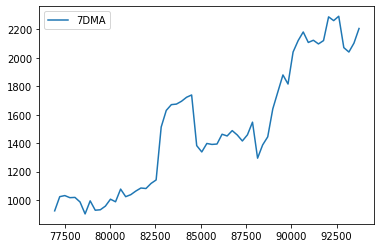

In [96]:
oxford_data[(oxford_data['GeoID']=='United States__Alabama') & (oxford_data.Date>='2020-10-01')][['7DMA']].plot()

<AxesSubplot:>

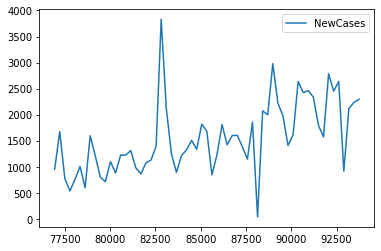

In [97]:
oxford_data[(oxford_data['GeoID']=='United States__Alabama') & (oxford_data.Date>='2020-10-01')][['NewCases']].plot()

### Model Training

In [98]:
def process_data(df, nb_lookback_days, nb_lookback_months, test_months, static, rolling, ff_index):   
    cases_col_used = ['7DMA'] if rolling else ['NewCases']
    # Create training data across all regions for predicting one day ahead
    if static:
      df = add_static_data(df)
      X_cols = cases_col_used + npi_cols + census_cols + lodes_cols
    else:
      X_cols = cases_col_used + npi_cols      
    y_cols = ['GeoID', 'Date'] + cases_col_used # Include GeoID and date to create graphs
    
    X_samples = []
    y_samples = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    train_date = SUBMISSION_DATE-np.timedelta64((nb_lookback_months+test_months)*30, 'D')
    geo_ids = df.GeoID.unique()
    for g in geo_ids:
        gdf = df[(df.GeoID == g) & (df.Date >= train_date)]
        all_case_data = np.array(gdf[cases_col_used])
        all_npi_data = np.array(gdf[npi_cols])
        
        if static:
          all_census_data = np.array(gdf[census_cols])
          all_lodes_data = np.array(gdf[lodes_cols])
        
        all_bookkeeping_data = np.array(gdf[y_cols])

        # Create one sample for each day where we have enough data
        # Each sample consists of cases and npis for previous nb_lookback_days
        nb_total_days = len(gdf)
        
        for d in range(nb_lookback_days, nb_total_days - 1):
            X_cases = all_case_data[d-nb_lookback_days:d]
            X_npis = all_npi_data[d - nb_lookback_days:d]
            X_npis_or = np.bitwise_or.reduce(X_npis, axis=0)
            
            # Flatten all input data
            if static:
              X_census = all_census_data[d-nb_lookback_days:d]
              X_lodes = all_census_data[d-nb_lookback_days:d]
              X_sample = np.concatenate([X_cases.flatten(),
                                         X_npis_or.flatten(),
                                         X_census.flatten(), X_lodes.flatten()])
              if len(ff_index) != 0:
                    X_sample = X_sample[:, np.array[ff_index]]
            else:
               X_sample = np.concatenate([X_cases.flatten(),X_npis_or.flatten()])              
            y_sample = all_bookkeeping_data[d]
            
            if d < nb_total_days-test_months*30:
                X_train.append(X_sample)
                y_train.append(y_sample)
            else:
                X_test.append(X_sample)
                y_test.append(y_sample)
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)[:,-1]
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [99]:
# Helpful function to compute mae
def mae(pred, true):
    return np.mean(np.abs(pred - true))
def add_static_data(df):
  for col in census_cols:
    df[col] = 0
  for idx, census_row in census_data.iterrows():
    for num, feat in enumerate(census_cols):
      df[feat] = np.where(df['RegionName'] == census_row[0], census_row[num + 1] , df[feat])

  for col in lodes_cols:
    df[col] = 0
  for idx, lodes_row in lodes_data.iterrows():
    for num, feat in enumerate(lodes_cols):
      df[feat] = np.where(df['RegionName'] == lodes_row[0], lodes_row[num + 1] , df[feat])    

  return df


In [100]:
def f_selection(df, nb_lookback_days, nb_lookback_months, test_months, model):
    df_copy = df.copy()
     # Create training data across all regions for predicting one day ahead
    df = add_static_data(df)
    X_cols = cases_col + npi_cols + census_cols + lodes_cols 
    y_cols = ['NewCases'] # Include GeoID and date to create graphs
    
    # Column indices for fixed features to be always considered in feature selection
    ff_index = tuple(range(nb_lookback_days*(len(cases_col)+len(npi_cols))))

    X_samples = []
    y_samples = []
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    train_date = SUBMISSION_DATE-np.timedelta64((nb_lookback_months+test_months)*30, 'D')
    geo_ids = df.GeoID.unique()
    for g in geo_ids:
        gdf = df[(df.GeoID == g) & (df.Date >= train_date)]
        all_case_data = np.array(gdf[cases_col])
        all_npi_data = np.array(gdf[npi_cols])        
        all_census_data = np.array(gdf[census_cols])
        all_lodes_data = np.array(gdf[lodes_cols])
        all_bookkeeping_data = np.array(gdf[y_cols])

        # Create one sample for each day where we have enough data
        # Each sample consists of cases and npis for previous nb_lookback_days
        nb_total_days = len(gdf)
        
        for d in range(nb_lookback_days, nb_total_days - 1):
            X_cases = all_case_data[d-nb_lookback_days:d]
            X_npis = all_npi_data[d - nb_lookback_days:d]

            # Flatten all input data
            X_census = all_census_data[d-nb_lookback_days:d]
            X_lodes = all_census_data[d-nb_lookback_days:d]
            X_sample = np.concatenate([X_cases.flatten(),
                                     X_npis.flatten(),
                                     X_census.flatten(), X_lodes.flatten()])            
            y_sample = all_bookkeeping_data[d]
            
            if d < nb_total_days-test_months*30:
                X_train.append(X_sample)
                y_train.append(y_sample)
            else:
                X_test.append(X_sample)
                y_test.append(y_sample)
    
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)[:,-1]
    y_test = np.array(y_test)
    
    fs_X = np.vstack((X_train,X_test))
    fs_y = np.hstack((y_train, y_test[:,-1]))
    fs_cv_in = np.array(list(range(X_train.shape[0]-1,fs_X.shape[0])))
    piter = PredefinedHoldoutSplit(fs_cv_in)
    sfs1 = sfs(model,
            k_features='parsimonious',
            forward=True,
            floating=False,
            verbose=0,
            scoring='neg_mean_absolute_error',
            cv=piter,
            fixed_features=ff_index)

    # Perform SFFS
    sfs1 = sfs1.fit(fs_X, fs_y)
    return sfs1.subsets_

In [156]:
def run(df, nb_lookback_days, nb_lookback_months, test_months, model, inspect, graph, static, rolling, ff_index=[]):
    df_copy = df.copy()
    X_train, X_test, y_train, y_test = process_data(df_copy,
                                                    nb_lookback_days, 
                                                    nb_lookback_months,
                                                    test_months,
                                                    static,
                                                    rolling,
                                                    ff_index
                                                   )
    print('Preprocessing done!')
    model.fit(X_train, y_train)
    print('Training done!')
    # Evaluate model
    train_preds = model.predict(X_train)
    train_preds = np.maximum(train_preds, 0) # Don't predict negative cases
    print('Train MAE:', mae(train_preds, y_train))
    test_preds = model.predict(X_test)
    test_preds = np.maximum(test_preds, 0) # Don't predict negative cases
    print('Test MAE:', mae(test_preds, y_test[:,-1]))
    
    # Inspect the learned feature coefficients for the model
    # to see what features it's paying attention to.
    if inspect:
        # Give names to the features
        x_col_names = []
        for d in range(-nb_lookback_days, 0):
            x_col_names.append('Day ' + str(d) + ' ' + cases_col[0])
        for d in range(-nb_lookback_days, 1):
            for col_name in npi_cols:
                x_col_names.append('Day ' + str(d) + ' ' + col_name)

        # View non-zero coefficients
        for (col, coeff) in zip(x_col_names, list(model.coef_)):
            if coeff != 0.:
                print(col, coeff)
        print('Intercept', model.intercept_)
        
    if graph:
        graph_np = np.hstack((y_test, test_preds.reshape(-1,1)))
        geo_ids = np.unique(graph_np[:,0])
        for geo_id in geo_ids:
            gnp = graph_np[graph_np[:,0]==geo_id, :]
            plt.figure()
            plt.plot(gnp[:,1], gnp[:,3], label='Prediction')
            plt.plot(gnp[:,1], gnp[:,2], label='Actual')
            plt.title(geo_id)
            plt.legend()
            plt.show()
            
    return model


In [157]:
f_sub = f_selection(oxford_data, 30, 20, 2, LinearRegression(), [])
f_sub

TypeError: f_selection() takes 5 positional arguments but 6 were given

In [159]:
model = run(df=oxford_data, 
            nb_lookback_days=30, 
            nb_lookback_months=20, 
            test_months=10, 
            model=LinearRegression(), 
            inspect=False, 
            graph=False, 
            static=False, 
            rolling=False, 
            ff_index=[])

Preprocessing done!
Training done!
Train MAE: 0.02587932400972308
Test MAE: 467.76862799866774


In [164]:
model = run(df=oxford_data, 
            nb_lookback_days=30, 
            nb_lookback_months=20, 
            test_months=10, 
            model=LinearRegression(), 
            inspect=False, 
            graph=False, 
            static=False, 
            rolling=True, 
            ff_index=[])

Preprocessing done!
Training done!
Train MAE: 0.003983392776098657
Test MAE: 71.34758168264898


In [72]:
# %%time
# model = run(oxford_data, 30, 20, 2, LinearRegression(), False, False, True)

In [21]:
model = run(oxford_data, 30, 20, 2, SVR(), False, False, False)

Train MAE: 307.0347168488861
Test MAE: 1322.6902174638083


In [22]:
# Takes more than a few minutes to fit.
# model = run(oxford_data, 30, 20, 2, SVR(), False, False, True)

In [161]:
model = run(df=oxford_data, 
            nb_lookback_days=30, 
            nb_lookback_months=20, 
            test_months=10, 
            model=GradientBoostingRegressor(), 
            inspect=False, 
            graph=False, 
            static=False, 
            rolling=False, 
            ff_index=[])


Preprocessing done!
Training done!
Train MAE: 0.003847284386046441
Test MAE: 859.5940792812173


Preprocessing done!
Training done!
Train MAE: 24.018338915038232
Test MAE: 147.579325242616


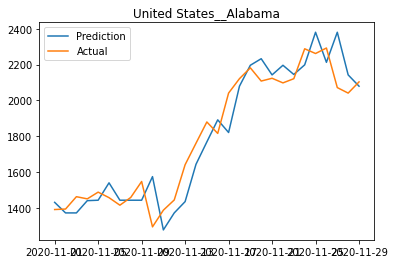

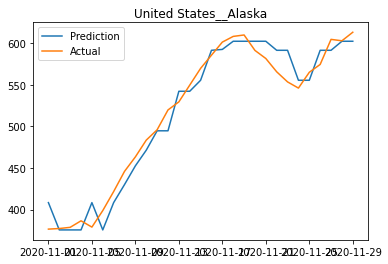

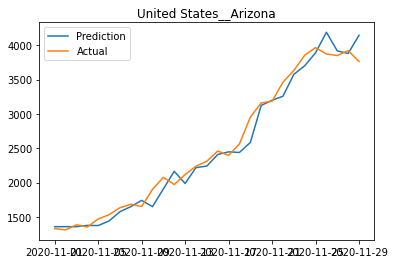

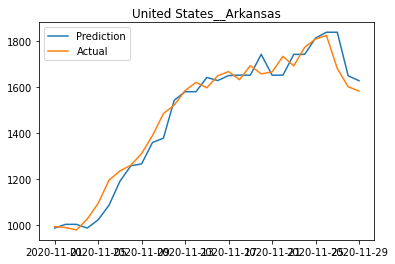

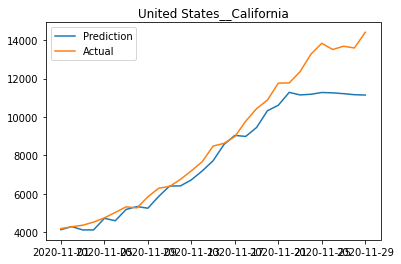

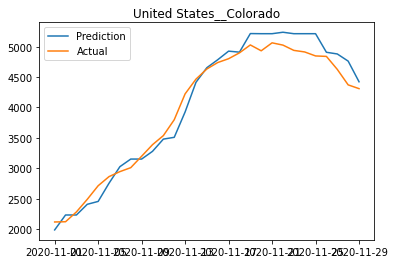

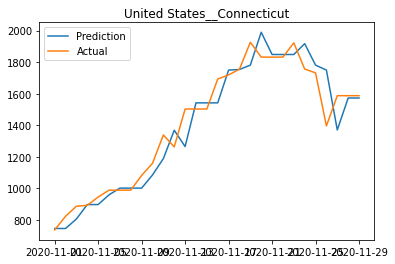

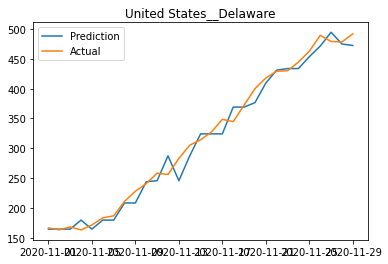

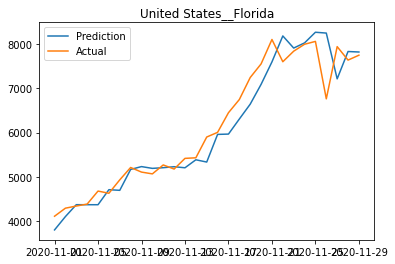

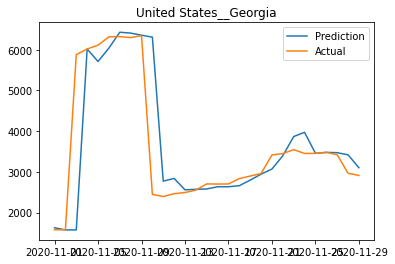

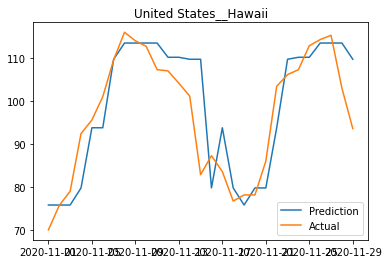

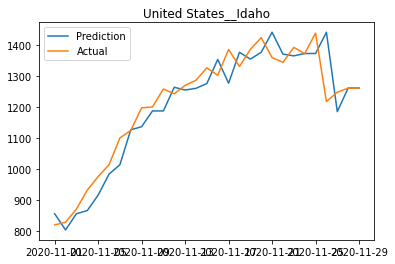

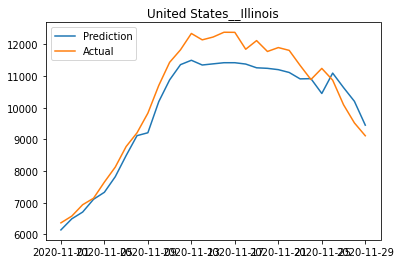

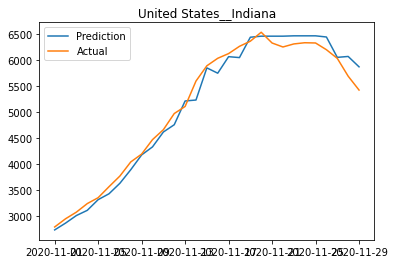

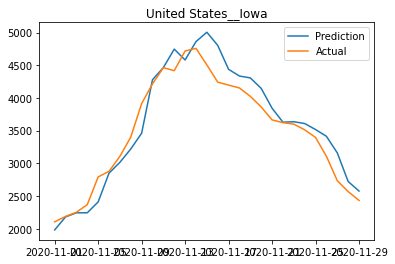

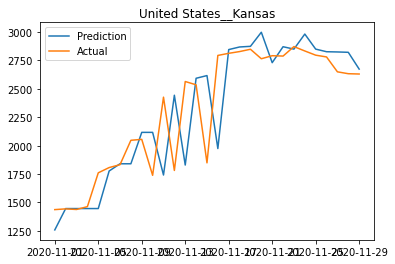

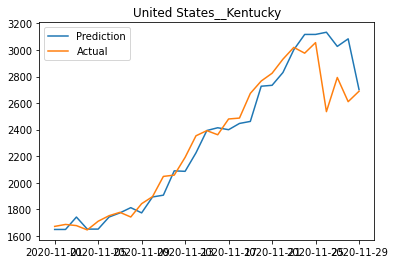

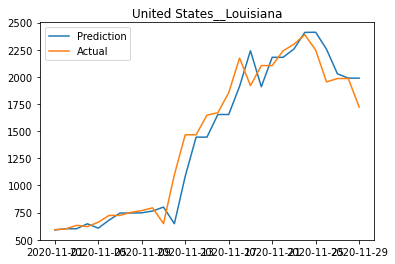

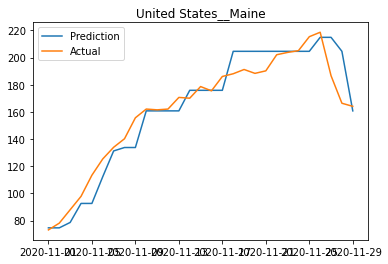

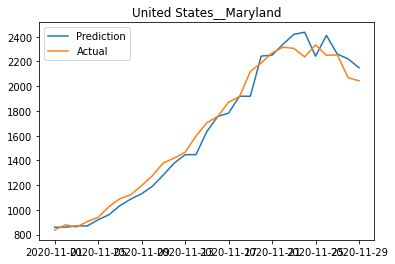

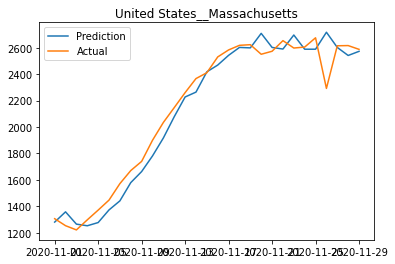

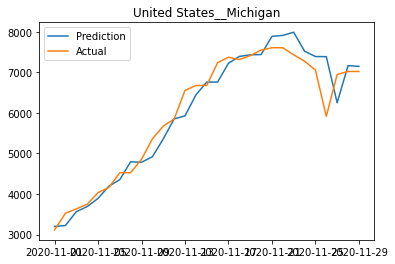

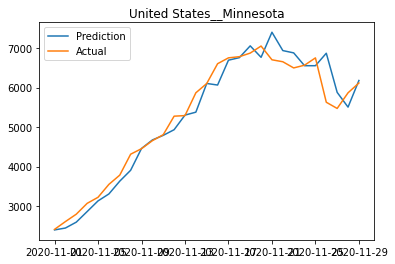

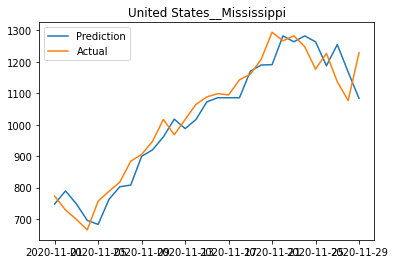

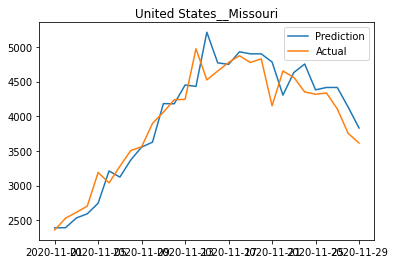

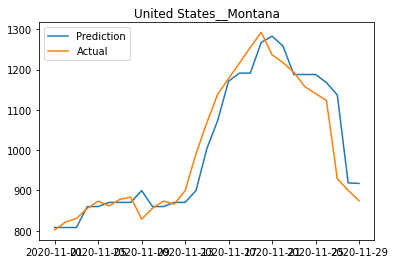

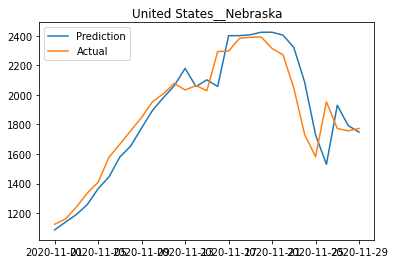

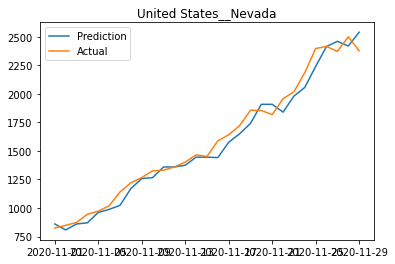

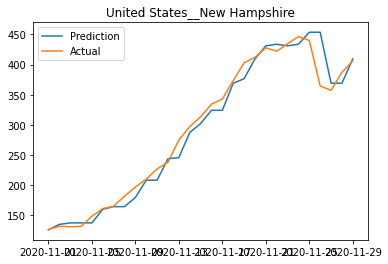

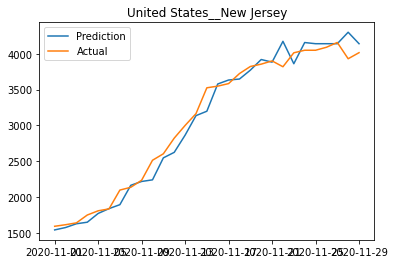

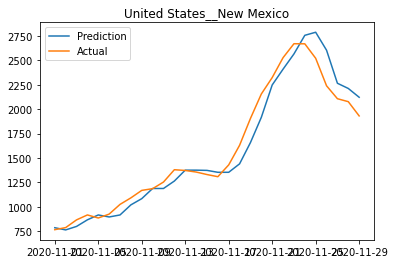

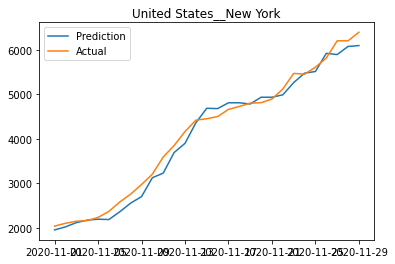

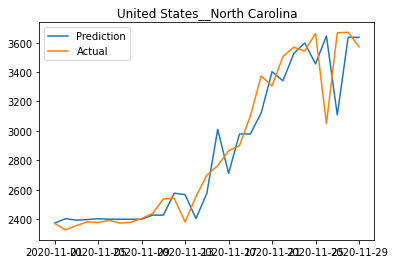

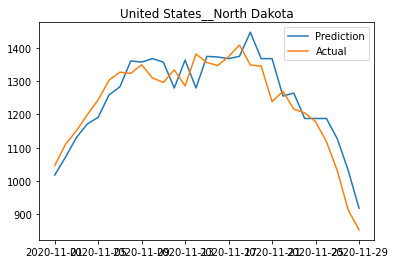

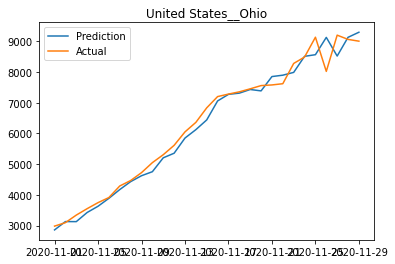

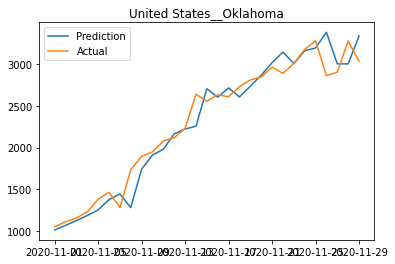

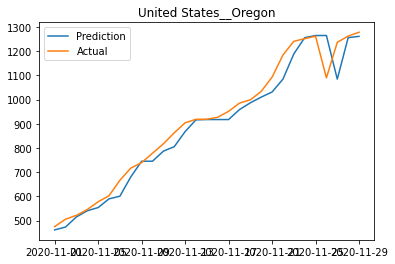

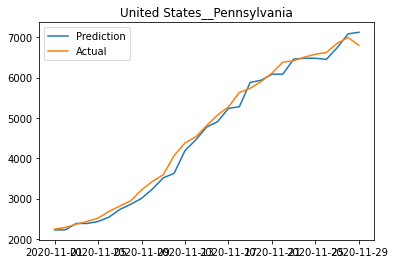

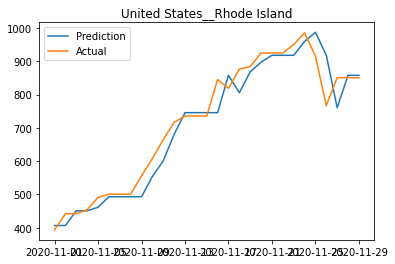

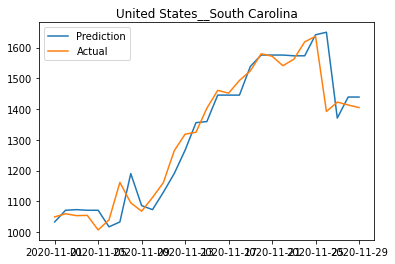

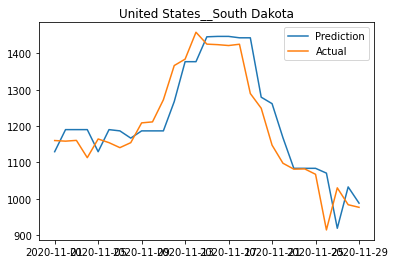

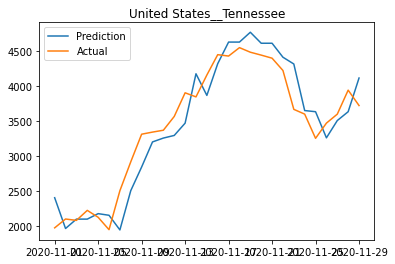

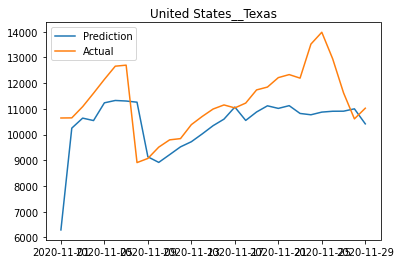

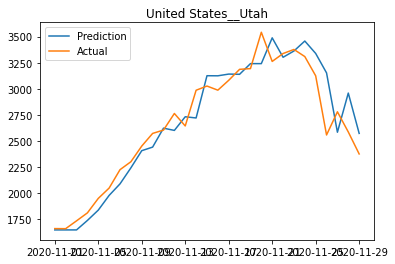

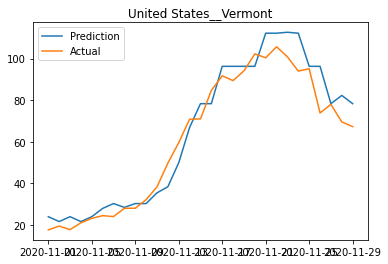

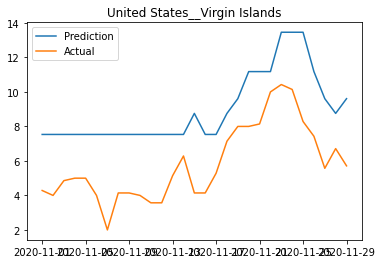

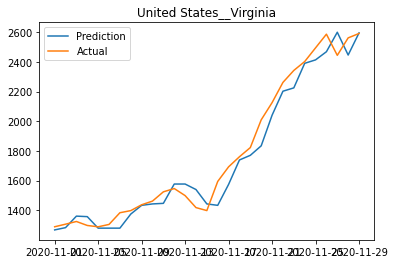

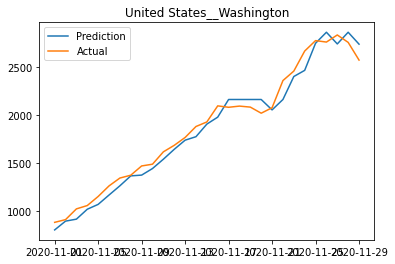

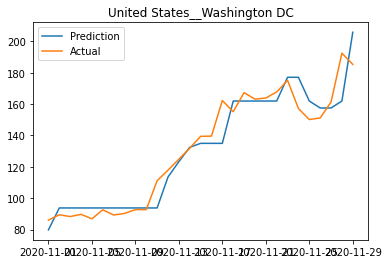

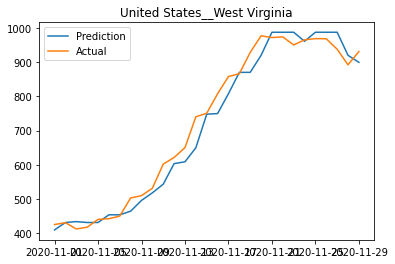

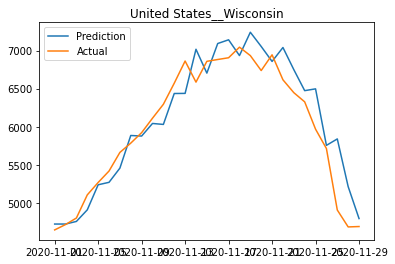

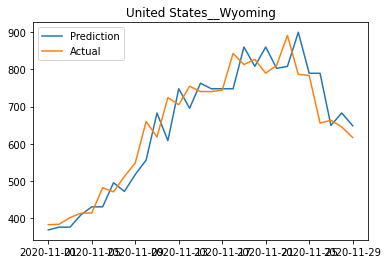

In [163]:
model = run(df=oxford_data, 
            nb_lookback_days=30, 
            nb_lookback_months=20, 
            test_months=1, 
            model=GradientBoostingRegressor(), 
            inspect=False, 
            graph=True, 
            static=False, 
            rolling=True, 
            ff_index=[])

In [24]:
# Takes more than a few minutes to fit.
# model = run(oxford_data, 30, 20, 2, GradientBoostingRegressor(), False, False, True)

In [25]:
model = run(oxford_data, 14, 20, 2, LinearRegression(), False, False, False)

Train MAE: 137.23989343572921
Test MAE: 564.4728729466882


In [26]:
# model = run(oxford_data, 14, 20, 2, LinearRegression(), False, False, True)

In [27]:
model = run(oxford_data, 14, 5, 3, LinearRegression(), False, False, False)

Train MAE: 182.0379520225632
Test MAE: 1164101.8777589097


In [28]:
# model = run(oxford_data, 14, 5, 3, LinearRegression(), False, False, True)

In [29]:
# Using their generic model because changes have to be made in evaluation if static features are used 
model = run(oxford_data, 30, 20, 2, LinearRegression(), False, False, False)




# Save model to file (this just stores whatever is the last uncommented model)
if not os.path.exists('models'):
    os.mkdir('models')
with open('models/model.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

Train MAE: 145.74426501856493
Test MAE: 563.4284272579357


## Evaluation

Now that the predictor has been trained and saved, this section contains the functionality for evaluating it on sample evaluation data. Make changes in predict.py since that's what is called

In [30]:
%%time
# Reload the module to get the latest changes
import predict
from importlib import reload
reload(predict)
from predict import predict_df
# doesnt work for non american regions rn because of different data sizes.. or 
preds_df = predict_df("2020-08-01", "2020-08-31", path_to_ips_file="../../../validation/data/2020-09-30_historical_ip.csv", verbose=True)


Predicting for Aruba__nan
2020-08-01: 0
2020-08-02: 28.160686492919922
2020-08-03: 42.902212142944336
2020-08-04: 0
2020-08-05: 140.52099514007568
2020-08-06: 483.73405361175537
2020-08-07: 234.98007678985596
2020-08-08: 358.0449104309082
2020-08-09: 255.91008186340332
2020-08-10: 315.7289457321167
2020-08-11: 320.86104583740234
2020-08-12: 573.8491487503052
2020-08-13: 455.8518400192261
2020-08-14: 459.48777294158936
2020-08-15: 347.4088010787964
2020-08-16: 290.16354274749756
2020-08-17: 423.69438457489014
2020-08-18: 607.1590366363525
2020-08-19: 545.1509809494019
2020-08-20: 481.1678457260132
2020-08-21: 343.67331409454346
2020-08-22: 411.0091886520386
2020-08-23: 260.74257946014404
2020-08-24: 247.64405155181885
2020-08-25: 78.92377376556396
2020-08-26: 382.52746295928955
2020-08-27: 361.4564905166626
2020-08-28: 207.61267852783203
2020-08-29: 242.06205940246582
2020-08-30: 0
2020-08-31: 220.36000442504883

Predicting for Afghanistan__nan
2020-08-01: 559.907075881958
2020-08-02: 

2020-08-01: 13245314.93341446
2020-08-02: 16545887.268096924
2020-08-03: 19856186.105653763
2020-08-04: 21855056.8066988
2020-08-05: 25259776.520284653
2020-08-06: 27772884.810884476
2020-08-07: 32955256.34735489
2020-08-08: 38288486.88249111
2020-08-09: 43720807.69521904
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 113139173.37508965
2020-08-14: 599635553.4976463
2020-08-15: 689458455.7365923
2020-08-16: 350883044.0770006
2020-08-17: 250541577.2413435
2020-08-18: 448423389.4143667
2020-08-19: 700789353.6924133
2020-08-20: 992665339.4295244
2020-08-21: 1082466252.6679
2020-08-22: 1158689522.4191065
2020-08-23: 767507801.8244886
2020-08-24: 759601928.5610304
2020-08-25: 868266818.7853289
2020-08-26: 746785939.931015
2020-08-27: 714393402.5301514
2020-08-28: 438512731.51803017
2020-08-29: 953614943.2473068
2020-08-30: 1150403332.7317314
2020-08-31: 1435028952.7880373

Predicting for Bangladesh__nan
2020-08-01: 2512.3294610977173
2020-08-02: 2516.538715362549
2020-08-03: 2685.200

2020-08-01: 0
2020-08-02: 91680646.46149158
2020-08-03: 577604823.4930468
2020-08-04: 662266959.5680456
2020-08-05: 329968043.88670826
2020-08-06: 233714036.9311781
2020-08-07: 436426243.7571058
2020-08-08: 687432237.1819124
2020-08-09: 975317782.0588865
2020-08-10: 1059310177.8487139
2020-08-11: 1133650133.9137945
2020-08-12: 744838422.8310299
2020-08-13: 743186432.6650667
2020-08-14: 856366677.949686
2020-08-15: 736868020.486886
2020-08-16: 703541652.9806509
2020-08-17: 421702362.41466427
2020-08-18: 934032743.2140322
2020-08-19: 1131678645.019886
2020-08-20: 1426004084.6059752
2020-08-21: 1455958441.562417
2020-08-22: 1408457113.1168137
2020-08-23: 1415347537.0537395
2020-08-24: 1332367973.0642834
2020-08-25: 890944865.0943851
2020-08-26: 1265528310.946209
2020-08-27: 1019261255.2943583
2020-08-28: 1333933865.6973038
2020-08-29: 1232103979.904708
2020-08-30: 1314306340.894682
2020-08-31: 1174706780.4435396

Predicting for Brazil__Amapa
2020-08-01: 0
2020-08-02: 91680523.80724812
202

2020-08-17: 421702261.51005936
2020-08-18: 934032435.6959591
2020-08-19: 1131678506.2912226
2020-08-20: 1426004003.1906996
2020-08-21: 1455958715.8192883
2020-08-22: 1408456940.258134
2020-08-23: 1415347630.5375137
2020-08-24: 1332368414.3270159
2020-08-25: 890944638.0576448
2020-08-26: 1265528274.6257668
2020-08-27: 1019261327.6468039
2020-08-28: 1326568702.2123919
2020-08-29: 1222903441.403695
2020-08-30: 1303265125.0427618
2020-08-31: 1162553970.8109426

Predicting for Brazil__Parana
2020-08-01: 0
2020-08-02: 91681378.2069912
2020-08-03: 577605122.5011024
2020-08-04: 662267297.5535755
2020-08-05: 329968050.7204256
2020-08-06: 233714519.72164726
2020-08-07: 436426590.8371763
2020-08-08: 687432804.6546688
2020-08-09: 975318303.8171816
2020-08-10: 1059310562.8859596
2020-08-11: 1133650543.7807665
2020-08-12: 744838818.9111195
2020-08-13: 743186400.5834312
2020-08-14: 856366934.6436272
2020-08-15: 736868330.3291626
2020-08-16: 703541985.4791193
2020-08-17: 421702599.2013159
2020-08-18: 

2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 116381607.44988918
2020-08-17: 601435419.2388229
2020-08-18: 689315862.373352
2020-08-19: 344763096.0696249
2020-08-20: 240168149.7098713
2020-08-21: 434460161.4540882
2020-08-22: 687694662.5450411
2020-08-23: 978152927.3496456
2020-08-24: 1066606882.7212324
2020-08-25: 1137746341.5926876
2020-08-26: 742411824.983942
2020-08-27: 728996306.3177967
2020-08-28: 834434153.0234461
2020-08-29: 711877099.8933907
2020-08-30: 678160474.78473
2020-08-31: 400020781.9965439

Predicting for Switzerland__nan
2020-08-01: 11.755966186523438
2020-08-02: 66.69866371154785
2020-08-03: 17.99500846862793
2020-08-04: 70.74928855895996
2020-08-05: 83.70674896240234
2020-08-06: 98.13810539245605
2020-08-07: 78.47148323059082
2020-08-08: 47.04679203033447
2020-08-09: 6.689016342163086
2020-08-10: 16.36752700805664
2020-08-11: 64.3862533569336
2020-08-12: 47.6059627532959
2020-08-13: 2.2559823989868164
2020-08-14: 16.088247299194336
2020-08-15: 52.7311334609

2020-08-08: 862.6064949035645
2020-08-09: 604.6424989700317
2020-08-10: 686.0867862701416
2020-08-11: 593.2829885482788
2020-08-12: 729.6946067810059
2020-08-13: 663.8999166488647
2020-08-14: 645.8375158309937
2020-08-15: 502.8182067871094
2020-08-16: 484.5860900878906
2020-08-17: 433.70311737060547
2020-08-18: 428.9507808685303
2020-08-19: 395.7176752090454
2020-08-20: 416.23319721221924
2020-08-21: 361.11651039123535
2020-08-22: 35.28797626495361
2020-08-23: 231.01019382476807
2020-08-24: 42.56931400299072
2020-08-25: 174.42516994476318
2020-08-26: 204.65892124176025
2020-08-27: 217.895733833313
2020-08-28: 75.38927268981934
2020-08-29: 241.63264560699463
2020-08-30: 170.95246982574463
2020-08-31: 5.886542320251465

Predicting for Djibouti__nan
2020-08-01: 0
2020-08-02: 85895289.30938148
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 52797780.714019775
2020-08-07: 306431192.29980755
2020-08-08: 625431141.2437935
2020-08-09: 751562054.1311569
2020-08-10: 663048615.9060268
2020-

2020-08-04: 2975.8291816711426
2020-08-05: 3090.284641265869
2020-08-06: 3210.376573562622
2020-08-07: 2385.328359603882
2020-08-08: 2551.272382736206
2020-08-09: 2662.6453895568848
2020-08-10: 3581.589147567749
2020-08-11: 2853.690586090088
2020-08-12: 3129.994631767273
2020-08-13: 3531.8350315093994
2020-08-14: 2527.698003768921
2020-08-15: 2273.3662452697754
2020-08-16: 2956.558385848999
2020-08-17: 3907.330439567566
2020-08-18: 2611.8942375183105
2020-08-19: 3062.3451976776123
2020-08-20: 3385.1224250793457
2020-08-21: 2654.150135040283
2020-08-22: 2221.6587524414062
2020-08-23: 3026.1053047180176
2020-08-24: 3244.647211074829
2020-08-25: 2929.8799657821655
2020-08-26: 3175.713819503784
2020-08-27: 3053.522077560425
2020-08-28: 2685.764904022217
2020-08-29: 2690.115674972534
2020-08-30: 2915.4759216308594
2020-08-31: 3002.640489578247

Predicting for Estonia__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-

2020-08-07: 331429359.18053627
2020-08-08: 122912976.16886616
2020-08-09: 461067103.02077484
2020-08-10: 454696519.3949518
2020-08-11: 462054305.01503754
2020-08-12: 295615898.67385006
2020-08-13: 305349093.07699966
2020-08-14: 270945544.1034727
2020-08-15: 363995611.02828884
2020-08-16: 461433070.99615383
2020-08-17: 514682144.12276363
2020-08-18: 487360962.15624714
2020-08-19: 424401250.0788088
2020-08-20: 326300588.6908121
2020-08-21: 319553933.17755127
2020-08-22: 404256127.4662962
2020-08-23: 431253127.46212006
2020-08-24: 455842117.6313181
2020-08-25: 438325156.33601665
2020-08-26: 360075249.20852184
2020-08-27: 244355916.27100277
2020-08-28: 323672967.97191715
2020-08-29: 331694062.67834854
2020-08-30: 420888932.6496391
2020-08-31: 453188051.67554474

Predicting for Ghana__nan
2020-08-01: 13246421.069965363
2020-08-02: 16547264.011803627
2020-08-03: 19857603.513691902
2020-08-04: 21856424.731193542
2020-08-05: 25261235.572307587
2020-08-06: 27774391.84650135
2020-08-07: 32956990

2020-08-19: 420244020.4613972
2020-08-20: 613664909.6810169
2020-08-21: 937352032.6812744
2020-08-22: 1249729175.1570606
2020-08-23: 1348507662.286912
2020-08-24: 1403241716.4024343
2020-08-25: 954690714.3307848
2020-08-26: 942710262.7034092
2020-08-27: 1039564362.6964979
2020-08-28: 1009602281.1555433
2020-08-29: 912753435.9550409
2020-08-30: 700410141.3613396
2020-08-31: 1145966791.2916803

Predicting for India__nan
2020-08-01: 13301093.809847832
2020-08-02: 16599633.39397335
2020-08-03: 19909169.080195427
2020-08-04: 21909114.136925697
2020-08-05: 25314570.097867966
2020-08-06: 27830274.65876198
2020-08-07: 33013373.172675133
2020-08-08: 38346493.417134285
2020-08-09: 43777329.95822239
2020-08-10: 48410185.509827614
2020-08-11: 52415492.322999
2020-08-12: 55899028.47117329
2020-08-13: 60533642.7747736
2020-08-14: 65573620.343462944
2020-08-15: 71730565.10488224
2020-08-16: 78061054.803689
2020-08-17: 83780591.56091976
2020-08-18: 89078769.45650005
2020-08-19: 93396952.71520138
2020-

2020-08-12: 31055406.69941902
2020-08-13: 33632836.12988472
2020-08-14: 36435197.75898647
2020-08-15: 39859414.72447014
2020-08-16: 43380743.85313034
2020-08-17: 46563128.72204971
2020-08-18: 49509073.31704426
2020-08-19: 51910252.22328949
2020-08-20: 54607727.56414127
2020-08-21: 57601327.09675312
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 4529406.5132780075
2020-08-29: 0
2020-08-30: 0
2020-08-31: 188960457.90680122

Predicting for Liberia__nan
2020-08-01: 7365735.963814735
2020-08-02: 9201075.57472992
2020-08-03: 11041850.902123451
2020-08-04: 12153355.37356186
2020-08-05: 14047026.692718506
2020-08-06: 15444429.678497314
2020-08-07: 18326230.828216553
2020-08-08: 21292120.608578682
2020-08-09: 24313124.33472061
2020-08-10: 26890747.215101242
2020-08-11: 29118198.342772484
2020-08-12: 31054291.722338676
2020-08-13: 33631517.834397316
2020-08-14: 36433822.53039932
2020-08-15: 39857821.67883015
2020-08-16: 43379271.61780453
2020-08-1

2020-08-19: 93345738.37484932
2020-08-20: 98196631.70351982
2020-08-21: 103579417.78181267
2020-08-22: 111110849.49769592
2020-08-23: 116399624.67803574
2020-08-24: 121875475.31767082
2020-08-25: 127066266.78195953
2020-08-26: 131275498.66739273
2020-08-27: 135405651.48963165
2020-08-28: 141275844.23486137
2020-08-29: 147653382.85642052
2020-08-30: 153163193.1511631
2020-08-31: 158600624.73685646

Predicting for Mauritius__nan
2020-08-01: 330079298.0167074
2020-08-02: 358022708.46318626
2020-08-03: 168101844.26402664
2020-08-04: 0
2020-08-05: 101862262.39273834
2020-08-06: 0
2020-08-07: 148718191.29520893
2020-08-08: 195442242.18799686
2020-08-09: 225239820.95678043
2020-08-10: 172617272.806221
2020-08-11: 148431476.254241
2020-08-12: 100421129.083045
2020-08-13: 126537691.51797009
2020-08-14: 167872325.1442194
2020-08-15: 219793673.91773224
2020-08-16: 244779069.44087696
2020-08-17: 237462727.46437836
2020-08-18: 196809331.7118597
2020-08-19: 160653922.91707802
2020-08-20: 152549084.2

2020-08-01: 7365245.048154831
2020-08-02: 9200514.698874474
2020-08-03: 11041646.805393219
2020-08-04: 12152850.63148117
2020-08-05: 14046408.338266373
2020-08-06: 15443991.116329193
2020-08-07: 18326131.30712509
2020-08-08: 21291859.82071495
2020-08-09: 24312520.2648983
2020-08-10: 26890281.848384857
2020-08-11: 29117887.701561928
2020-08-12: 31053901.955303192
2020-08-13: 33631050.02075577
2020-08-14: 29068161.62823105
2020-08-15: 30656933.96882534
2020-08-16: 32337455.32433796
2020-08-17: 34408138.50110245
2020-08-18: 35460973.31960106
2020-08-19: 36464812.32396984
2020-08-20: 36280669.8724184
2020-08-21: 36308367.73729515
2020-08-22: 37475789.84332943
2020-08-23: 37839394.90909004
2020-08-24: 0
2020-08-25: 0
2020-08-26: 920329615.1610298
2020-08-27: 0
2020-08-28: 190540563.55202007
2020-08-29: 1949017727.4057837
2020-08-30: 2067587247.1818914
2020-08-31: 0

Predicting for Portugal__nan
2020-08-01: 306.42030906677246
2020-08-02: 406.7397985458374
2020-08-03: 563.8341836929321
2020-0

2020-08-01: 0
2020-08-02: 31510609.967525482
2020-08-03: 289767495.61598015
2020-08-04: 589531857.8021765
2020-08-05: 717182405.918458
2020-08-06: 629385565.7839403
2020-08-07: 633037065.4154406
2020-08-08: 431985346.26121616
2020-08-09: 0
2020-08-10: 427217567.6026726
2020-08-11: 218825727.89854622
2020-08-12: 550693499.6375093
2020-08-13: 516615392.95553684
2020-08-14: 523843345.94000244
2020-08-15: 358126673.98857975
2020-08-16: 377730615.53740406
2020-08-17: 366619686.9513521
2020-08-18: 469342833.7744322
2020-08-19: 558638403.5855255
2020-08-20: 605385122.5975094
2020-08-21: 547771994.878314
2020-08-22: 493660238.7777891
2020-08-23: 401609770.22491074
2020-08-24: 433636560.36675453
2020-08-25: 476715164.2735987
2020-08-26: 510959759.2703829
2020-08-27: 536239302.2736139
2020-08-28: 492696901.4437628
2020-08-29: 411965202.5486145
2020-08-30: 314535359.2990217
2020-08-31: 423410664.30714035

Predicting for Senegal__nan
2020-08-01: 0
2020-08-02: 78529687.63336849
2020-08-03: 0
2020-0

2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Syria__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Chad__nan
2020-08-01: 13245755.008816719
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-0

2020-08-17: 4690.800800323486
2020-08-18: 4741.314527511597
2020-08-19: 4885.875080108643
2020-08-20: 5181.565140724182
2020-08-21: 5426.43558216095
2020-08-22: 5889.4238538742065
2020-08-23: 5908.1227560043335
2020-08-24: 6105.820271492004
2020-08-25: 6211.566393852234
2020-08-26: 6407.728451728821
2020-08-27: 6704.1380071640015
2020-08-28: 7036.121505737305
2020-08-29: 133397063.65660286
2020-08-30: 98043481.96681976
2020-08-31: 91549931.66164494

Predicting for Uruguay__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 68.71088981628418
2020-08-16: 267.9544448852539
2020-08-17: 330.62908267974854
2020-08-18: 384.18388652801514
2020-08-19: 374.56266593933105
2020-08-20: 704.173192024231
2020-08-21: 927.2382507324219
2020-08-22: 785.8309640884399
2020-08-23: 908.8902978897095
2020-08-24: 1041.6086149215698
2020-08-25: 1237.98

56687              885.423202  

Predicting for United States__Arizona
2020-08-01: 2264.93182182312
2020-08-02: 2105.1709146499634
2020-08-03: 1751.534888267517
2020-08-04: 2051.0430793762207
2020-08-05: 1976.4144792556763
2020-08-06: 2274.941619873047
2020-08-07: 2517.0865240097046
2020-08-08: 1927.9970626831055
2020-08-09: 1739.4484510421753
2020-08-10: 1600.3873510360718
2020-08-11: 1985.5000820159912
2020-08-12: 1572.8281326293945
2020-08-13: 2144.393228530884
2020-08-14: 2267.1606702804565
2020-08-15: 1861.921672821045
2020-08-16: 1618.178650856018
2020-08-17: 1664.6754817962646
2020-08-18: 1680.862853050232
2020-08-19: 1731.640751838684
2020-08-20: 1880.7054090499878
2020-08-21: 2119.5921421051025
2020-08-22: 1761.1644496917725
2020-08-23: 1504.3054084777832
2020-08-24: 1478.7064247131348
2020-08-25: 1639.9695091247559
2020-08-26: 1566.087631225586
2020-08-27: 1841.44580078125
2020-08-28: 1748.700180053711
2020-08-29: 1732.8689765930176
2020-08-30: 1513.7706785202026
2020-08-31: 

2020-08-14: 325.15732765197754
2020-08-15: 266.118444442749
2020-08-16: 352.6045608520508
2020-08-17: 339.11745834350586
2020-08-18: 324.88283920288086
2020-08-19: 329.668981552124
2020-08-20: 347.3499937057495
2020-08-21: 354.11189365386963
2020-08-22: 369.9979705810547
2020-08-23: 411.92807960510254
2020-08-24: 391.229284286499
2020-08-25: 415.10680198669434
2020-08-26: 387.0896282196045
2020-08-27: 399.42652702331543
2020-08-28: 407.24005222320557
2020-08-29: 429.2077445983887
2020-08-30: 469.93720626831055
2020-08-31: 552.0459880828857
         CountryName RegionName                    GeoID       Date  \
58301  United States   Delaware  United States__Delaware 2020-08-01   
58302  United States   Delaware  United States__Delaware 2020-08-02   
58303  United States   Delaware  United States__Delaware 2020-08-03   
58304  United States   Delaware  United States__Delaware 2020-08-04   
58305  United States   Delaware  United States__Delaware 2020-08-05   
58306  United States   Delaw

2020-08-01: 1571.410490989685
2020-08-02: 1265.0169315338135
2020-08-03: 1322.8426532745361
2020-08-04: 1363.3551654815674
2020-08-05: 1460.749285697937
2020-08-06: 1710.1879987716675
2020-08-07: 1740.57772731781
2020-08-08: 1641.6056985855103
2020-08-09: 1419.9719133377075
2020-08-10: 1364.5824670791626
2020-08-11: 1297.9033117294312
2020-08-12: 1524.9766645431519
2020-08-13: 1590.4236555099487
2020-08-14: 1628.76060962677
2020-08-15: 1561.3471536636353
2020-08-16: 1436.8367586135864
2020-08-17: 1263.102536201477
2020-08-18: 1248.4537324905396
2020-08-19: 1425.7179250717163
2020-08-20: 1515.5072526931763
2020-08-21: 1541.4417295455933
2020-08-22: 1445.7252588272095
2020-08-23: 1331.9105653762817
2020-08-24: 1223.6654844284058
2020-08-25: 1190.3974771499634
2020-08-26: 1277.4750967025757
2020-08-27: 1421.081810951233
2020-08-28: 1422.2797174453735
2020-08-29: 1332.2604036331177
2020-08-30: 1217.6057176589966
2020-08-31: 1144.3077516555786
         CountryName RegionName                

2020-08-01: 108.6112003326416
2020-08-02: 0
2020-08-03: 88.82174301147461
2020-08-04: 1.2369670867919922
2020-08-05: 51.89551830291748
2020-08-06: 0
2020-08-07: 0
2020-08-08: 36.07175254821777
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 33.04538631439209
2020-08-13: 6.125414848327637
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0.6083059310913086
2020-08-17: 0
2020-08-18: 14.27913761138916
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0
         CountryName RegionName                 GeoID       Date  \
61863  United States      Maine  United States__Maine 2020-08-01   
61864  United States      Maine  United States__Maine 2020-08-02   
61865  United States      Maine  United States__Maine 2020-08-03   
61866  United States      Maine  United States__Maine 2020-08-04   
61867  United States      Maine  United States__Maine 2020-08-05   
61868  Unite

         CountryName    RegionName                        GeoID       Date  \
63781  United States  North Dakota  United States__North Dakota 2020-08-01   
63782  United States  North Dakota  United States__North Dakota 2020-08-02   
63783  United States  North Dakota  United States__North Dakota 2020-08-03   
63784  United States  North Dakota  United States__North Dakota 2020-08-04   
63785  United States  North Dakota  United States__North Dakota 2020-08-05   
63786  United States  North Dakota  United States__North Dakota 2020-08-06   
63787  United States  North Dakota  United States__North Dakota 2020-08-07   
63788  United States  North Dakota  United States__North Dakota 2020-08-08   
63789  United States  North Dakota  United States__North Dakota 2020-08-09   
63790  United States  North Dakota  United States__North Dakota 2020-08-10   
63791  United States  North Dakota  United States__North Dakota 2020-08-11   
63792  United States  North Dakota  United States__North Dakota 

2020-08-01: 1030.431881904602
2020-08-02: 1035.095645904541
2020-08-03: 1094.460165977478
2020-08-04: 1299.6077671051025
2020-08-05: 1140.4928121566772
2020-08-06: 1031.1456909179688
2020-08-07: 1123.567021369934
2020-08-08: 1168.266324043274
2020-08-09: 1034.791618347168
2020-08-10: 1228.7894687652588
2020-08-11: 1372.1036596298218
2020-08-12: 1224.8213396072388
2020-08-13: 1143.5917930603027
2020-08-14: 1242.4728870391846
2020-08-15: 1121.32652759552
2020-08-16: 1133.8073902130127
2020-08-17: 1233.8694133758545
2020-08-18: 1235.2515335083008
2020-08-19: 1179.87748336792
2020-08-20: 1222.2228298187256
2020-08-21: 1128.714192390442
2020-08-22: 1155.0222730636597
2020-08-23: 1223.685878753662
2020-08-24: 1226.53874874115
2020-08-25: 1238.1181688308716
2020-08-26: 1234.3268642425537
2020-08-27: 1270.8471031188965
2020-08-28: 1152.8235778808594
2020-08-29: 1197.6761255264282
2020-08-30: 1169.1080980300903
2020-08-31: 1266.861367225647
         CountryName RegionName                    Geo

67921             3917.183595  

Predicting for United States__Utah
2020-08-01: 495.87778759002686
2020-08-02: 410.013370513916
2020-08-03: 369.6328830718994
2020-08-04: 365.342698097229
2020-08-05: 373.46442222595215
2020-08-06: 486.2897939682007
2020-08-07: 484.89375591278076
2020-08-08: 518.1993913650513
2020-08-09: 461.97671127319336
2020-08-10: 310.6508102416992
2020-08-11: 356.8442668914795
2020-08-12: 379.4140291213989
2020-08-13: 502.30364418029785
2020-08-14: 548.1023044586182
2020-08-15: 530.2228908538818
2020-08-16: 432.5083990097046
2020-08-17: 350.88317680358887
2020-08-18: 384.9677400588989
2020-08-19: 421.7020034790039
2020-08-20: 617.9406776428223
2020-08-21: 565.5185108184814
2020-08-22: 572.1941318511963
2020-08-23: 530.2513437271118
2020-08-24: 515.3482418060303
2020-08-25: 457.361536026001
2020-08-26: 585.446662902832
2020-08-27: 671.3193674087524
2020-08-28: 706.3521213531494
2020-08-29: 634.0506620407104
2020-08-30: 628.0062599182129
2020-08-31: 588.294599533081
 

2020-08-13: 13.584118843078613
2020-08-14: 0
2020-08-15: 0
2020-08-16: 14.1387357711792
2020-08-17: 0
2020-08-18: 18.605725288391113
2020-08-19: 0
2020-08-20: 11.239307403564453
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 2.1713056564331055
2020-08-27: 71.44974708557129
2020-08-28: 0
2020-08-29: 13.335633277893066
2020-08-30: 1.2489137649536133
2020-08-31: 10.2914400100708
         CountryName RegionName                   GeoID       Date  \
70083  United States    Wyoming  United States__Wyoming 2020-08-01   
70084  United States    Wyoming  United States__Wyoming 2020-08-02   
70085  United States    Wyoming  United States__Wyoming 2020-08-03   
70086  United States    Wyoming  United States__Wyoming 2020-08-04   
70087  United States    Wyoming  United States__Wyoming 2020-08-05   
70088  United States    Wyoming  United States__Wyoming 2020-08-06   
70089  United States    Wyoming  United States__Wyoming 2020-08-07   
70090  United States    Wy

Wall time: 8.89 s


In [31]:
# Check the predictions
preds_df[preds_df['CountryName']=='United States'].tail()

,CountryName,RegionName,Date,PredictedDailyNewCases
70109,United States,Wyoming,2020-08-27,71.449747
70110,United States,Wyoming,2020-08-28,0.000000
70111,United States,Wyoming,2020-08-29,13.335633
70112,United States,Wyoming,2020-08-30,1.248914
70113,United States,Wyoming,2020-08-31,10.291440


# Validation
This is how the predictor is going to be called during the competition.  
!!! PLEASE DO NOT CHANGE THE API !!!

In [32]:
!python predict.py -s 2020-08-01 -e 2020-08-04 -ip ../../../validation/data/2020-09-30_historical_ip.csv -o predictions/2020-08-01_2020-08-04.csv

Generating predictions from 2020-08-01 to 2020-08-04...
         CountryName RegionName  ...       Date PredictedDailyNewCases
55835  United States        NaN  ... 2020-08-01           59864.591428
55836  United States        NaN  ... 2020-08-02           56612.880235
55837  United States        NaN  ... 2020-08-03           55446.758445
55838  United States        NaN  ... 2020-08-04           59071.341130

[4 rows x 5 columns]
         CountryName RegionName  ...       Date PredictedDailyNewCases
56109  United States     Alaska  ... 2020-08-01             283.562445
56110  United States     Alaska  ... 2020-08-02             298.312462
56111  United States     Alaska  ... 2020-08-03             278.282489
56112  United States     Alaska  ... 2020-08-04             208.027366

[4 rows x 5 columns]
         CountryName RegionName  ...       Date PredictedDailyNewCases
56383  United States    Alabama  ... 2020-08-01            1622.205029
56384  United States    Alabama  ... 2020-08-02 

In [33]:
!head predictions/2020-08-01_2020-08-04.csv

61864  United States      Maine  ... 2020-08-02               0.000000
61865  United States      Maine  ... 2020-08-03              88.821743
61866  United States      Maine  ... 2020-08-04               1.236967

[4 rows x 5 columns]
         CountryName RegionName  ...       Date PredictedDailyNewCases
62137  United States   Michigan  ... 2020-08-01             764.577760
62138  United States   Michigan  ... 2020-08-02             640.207680
62139  United States   Michigan  ... 2020-08-03             710.237193
62140  United States   Michigan  ... 2020-08-04             813.399918

[4 rows x 5 columns]
         CountryName RegionName  ...       Date PredictedDailyNewCases
62411  United States  Minnesota  ... 2020-08-01             809.478265
62412  United States  Minnesota  ... 2020-08-02             782.255027
62413  United States  Minnesota  ... 2020-08-03             693.621114
62414  United States  Minnesota  ... 2020-08-04             674.915063

[4 rows x 5 columns]
         Co

# Test cases
We can generate a prediction file. Let's validate a few cases...

In [34]:
import os
from covid_xprize.validation.predictor_validation import validate_submission

def validate(start_date, end_date, ip_file, output_file):
    # First, delete any potential old file
    try:
        os.remove(output_file)
    except OSError:
        pass
    
    # Then generate the prediction, calling the official API
    !python predict.py -s {start_date} -e {end_date} -ip {ip_file} -o {output_file}
    
    # And validate it
    errors = validate_submission(start_date, end_date, ip_file, output_file)
    if errors:
        for error in errors:
            print(error)
    else:
        print("All good!")

## 4 days, no gap
- All countries and regions
- Official number of cases is known up to start_date
- Intervention Plans are the official ones

In [35]:
validate(start_date="2020-08-01",
         end_date="2020-08-04",
         ip_file="../../../validation/data/2020-09-30_historical_ip.csv",
         output_file="predictions/val_4_days.csv")

Generating predictions from 2020-08-01 to 2020-08-04...
         CountryName RegionName  ...       Date PredictedDailyNewCases
55835  United States        NaN  ... 2020-08-01           59864.591428
55836  United States        NaN  ... 2020-08-02           56612.880235
55837  United States        NaN  ... 2020-08-03           55446.758445
55838  United States        NaN  ... 2020-08-04           59071.341130

[4 rows x 5 columns]
         CountryName RegionName  ...       Date PredictedDailyNewCases
56109  United States     Alaska  ... 2020-08-01             283.562445
56110  United States     Alaska  ... 2020-08-02             298.312462
56111  United States     Alaska  ... 2020-08-03             278.282489
56112  United States     Alaska  ... 2020-08-04             208.027366

[4 rows x 5 columns]
         CountryName RegionName  ...       Date PredictedDailyNewCases
56383  United States    Alabama  ... 2020-08-01            1622.205029
56384  United States    Alabama  ... 2020-08-02 

All good!


## 1 month in the future
- 2 countries only
- there's a gap between date of last known number of cases and start_date
- For future dates, Intervention Plans contains scenarios for which predictions are requested to answer the question: what will happen if we apply these plans?

In [36]:
%%time
validate(start_date="2021-01-01",
         end_date="2021-01-31",
         ip_file="../../../validation/data/future_ip.csv",
         output_file="predictions/val_1_month_future.csv")

Generating predictions from 2021-01-01 to 2021-01-31...
Saved predictions to predictions/val_1_month_future.csv
Done!
All good!
Wall time: 2.68 s


## 180 days, from a future date, all countries and regions
- Prediction start date is 1 week from now. (i.e. assuming submission date is 1 week from now)  
- Prediction end date is 6 months after start date.  
- Prediction is requested for all available countries and regions.  
- Intervention plan scenario: freeze last known intervention plans for each country and region.  

As the number of cases is not known yet between today and start date, but the model relies on them, the model has to predict them in order to use them.  
This test is the most demanding test. It should take less than 1 hour to generate the prediction file.

### Generate the scenario

In [37]:
from datetime import datetime, timedelta

start_date = datetime.now() + timedelta(days=7)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date = start_date + timedelta(days=180)
end_date_str = end_date.strftime('%Y-%m-%d')
print(f"Start date: {start_date_str}")
print(f"End date: {end_date_str}")

Start date: 2020-12-24
End date: 2021-06-22


In [38]:
from covid_xprize.validation.scenario_generator import get_raw_data, generate_scenario, NPI_COLUMNS
DATA_FILE = 'data/OxCGRT_latest.csv'
latest_df = get_raw_data(DATA_FILE, latest=True)
scenario_df = generate_scenario(start_date_str, end_date_str, latest_df, countries=None, scenario="Freeze")
scenario_file = "predictions/180_days_future_scenario.csv"
scenario_df.to_csv(scenario_file, index=False)
print(f"Saved scenario to {scenario_file}")

Saved scenario to predictions/180_days_future_scenario.csv


### Check it

In [39]:
%%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=scenario_file,
         output_file="predictions/val_6_month_future.csv")

Generating predictions from 2020-12-24 to 2021-06-22...
          CountryName RegionName  ...       Date PredictedDailyNewCases
117860  United States        NaN  ... 2020-12-24           55858.797766
117861  United States        NaN  ... 2020-12-25           69283.495621
117862  United States        NaN  ... 2020-12-26           68810.171359
117863  United States        NaN  ... 2020-12-27           72196.534278
117864  United States        NaN  ... 2020-12-28           58506.691424
...               ...        ...  ...        ...                    ...
118036  United States        NaN  ... 2021-06-18            1779.248300
118037  United States        NaN  ... 2021-06-19            1845.088783
118038  United States        NaN  ... 2021-06-20            1950.105624
118039  United States        NaN  ... 2021-06-21            2013.325901
118040  United States        NaN  ... 2021-06-22            1987.611796

[181 rows x 5 columns]
          CountryName RegionName  ...       Date Predict

All good!
Wall time: 16.1 s
